In [4]:
import pandas as pd
typeg_data=pd.read_csv("./data/2330_TW.csv")

typeg_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-08,509.0,509.0,502.0,504.0,493.968842,11243634
1,2023-05-09,507.0,510.0,505.0,510.0,499.849426,16197743
2,2023-05-10,508.0,508.0,500.0,503.0,492.988739,18859212
3,2023-05-11,506.0,506.0,498.5,499.0,489.068359,13382927
4,2023-05-12,496.0,500.0,495.0,496.0,486.128113,18465362
...,...,...,...,...,...,...,...
239,2024-04-30,797.0,802.0,790.0,790.0,790.000000,39051972
240,2024-05-02,789.0,789.0,772.0,772.0,772.000000,40527228
241,2024-05-03,788.0,788.0,773.0,780.0,780.000000,29901556
242,2024-05-06,791.0,793.0,786.0,786.0,786.000000,32599878


In [5]:
# test_10day=typeg_data.rename(columns={'Close':'clo'})

# test_day=test_10day.filter(['clo'])

test_day=typeg_data.rename(columns={'Close':'clo'}).filter(['clo'])
test_day=test_day.reset_index(drop=True);test_day

,clo
0,504.0
1,510.0
2,503.0
3,499.0
4,496.0
...,...
239,790.0
240,772.0
241,780.0
242,786.0


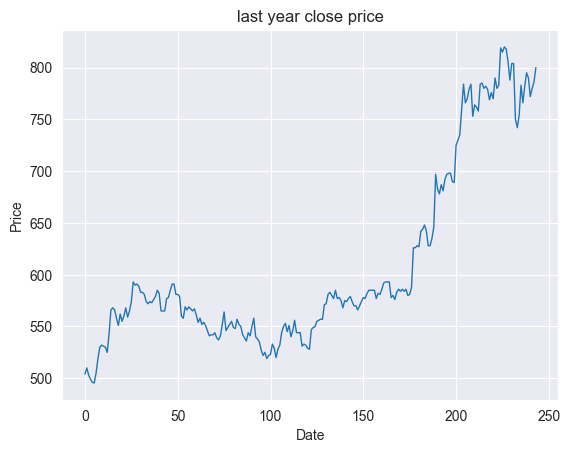

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
# plt.style.use("seaborn-darkgrid")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('last year close price')
# plt.plot(test_10day['High']-test_10day['clo'],linewidth=1)
plt.plot(test_day['clo'],linewidth=1)

plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as  np

MOVING_WIN_SIZE=35

scaler=MinMaxScaler(feature_range=(0,1))
scaler_prices=scaler.fit_transform(test_day.values)

all_x,all_y=[],[]
for i in range(len(scaler_prices)-MOVING_WIN_SIZE):
    x=scaler_prices[i:i+MOVING_WIN_SIZE]
    y=scaler_prices[i+MOVING_WIN_SIZE]
    all_x.append(x)
    all_y.append(y)

all_x,all_y=np.array(all_x),np.array(all_y)

In [8]:
DS_SPLIT=0.8

train_ds_size=round(all_x.shape[0]*DS_SPLIT)
train_x,train_y=all_x[:train_ds_size],all_y[:train_ds_size]
test_x,test_y=all_x[train_ds_size:],all_y[train_ds_size:]

In [9]:
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential

model =Sequential()
model.add(LSTM(units=128,return_sequences=True,input_shape=(train_x.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.summary()

c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 35, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,661 (404.93 KB)

 Trainable params: 103,661 (404.93 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer="adam",loss="mean_squared_error")

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=30, min_lr=0.000001, verbose=1)
callback=EarlyStopping( monitor="val_loss",patience=100,restore_best_weights=True)
model.fit(train_x,train_y,
          validation_split=0.2,
          callbacks=[callback,reduce_lr],
          epochs=1000
          )

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0251 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0045 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0020 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0018 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 10/1000
5/5 ━

In [12]:
preds=scaler.inverse_transform(model.predict(test_x))
preds

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


array([[731.8793 ],
       [735.7984 ],
       [758.5002 ],
       [781.0738 ],
       [763.5609 ],
       [767.89154],
       [777.6288 ],
       [783.1329 ],
       [754.69745],
       [767.08563],
       [766.28827],
       [763.21155],
       [787.75726],
       [787.6776 ],
       [782.4362 ],
       [784.6433 ],
       [782.0645 ],
       [773.20435],
       [780.2952 ],
       [774.4061 ],
       [792.58484],
       [781.8845 ],
       [784.48737],
       [817.5105 ],
       [811.03143],
       [815.5148 ],
       [813.5593 ],
       [803.041  ],
       [788.12573],
       [805.0673 ],
       [804.1455 ],
       [754.4417 ],
       [750.4996 ],
       [761.4221 ],
       [786.0132 ],
       [768.02203],
       [781.24036],
       [791.4725 ],
       [785.5462 ],
       [769.1333 ],
       [777.2448 ],
       [782.57086]], dtype=float32)

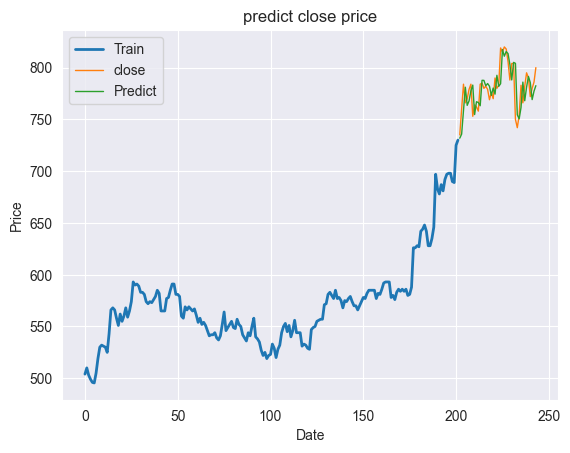

In [13]:
train_data=test_day[:train_ds_size+MOVING_WIN_SIZE]
test_data=test_day[train_ds_size+MOVING_WIN_SIZE:]
test_data=test_data.assign(Predict=preds)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title('predict close price')
plt.plot(train_data['clo'],linewidth=2)
plt.plot(test_data['clo'],linewidth=1)
plt.plot(test_data['Predict'],linewidth=1)

plt.legend(["Train","close","Predict"])
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

test_data=test_data.assign(Shifted=test_data['clo'].shift(1))
test_data.iat[0,-1]=train_data.iat[-1,-1]

predict_mse=mean_squared_error(test_data['clo'],test_data['Predict'],squared=False)
predict_cvrmse=predict_mse / test_data['clo'].mean()*100

shifted_rmse=mean_squared_error(test_data['clo'],test_data['Shifted'],squared=False)
shifted_cvrmse=shifted_rmse / test_data['clo'].mean()*100


print(f"predict_mse\t=  {predict_cvrmse} % \nshift_mse\t=  {shifted_cvrmse} %")

predict_mse	=  2.059203522201538 % 
shift_mse	=  2.1276107527822123 %


c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
model.save('./tsmc_v1.h5')